# Lab 2: Grayscale Colorizer

# Exercise 1

## 1. Dataset and preprocessing
We use the CIFAR-10 dataset (60,000 colour images of size 32×32×3 in 10 classes).  
Pixels are normalised to the [0,1] range using `ToTensor()`.  
We merge the original train and test splits and randomly divide them into:
- 80% training
- 10% validation
- 10% test

This split is done with `random_split` from PyTorch.

In [63]:
import torch, torchvision
from torch.utils.data import random_split, DataLoader, ConcatDataset
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.ToTensor(),                
])

all_data = ConcatDataset([
    datasets.CIFAR10(root="./data", train=True,  download=True, transform=transform),
    datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
])

n = len(all_data)

# Get sizes for train test and val
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = int(0.1 * n)

train_set, val_set, test_set = random_split(all_data, [n_train, n_val, n_test])

# DataLoaders, why do we shuffle only train?
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=128, shuffle=False)



## 2. Convolutional autoencoder architecture

The autoencoder compresses 32×32 RGB images into a low-dimensional latent representation and then reconstructs them.

**Encoder:**
- Conv2d: 3 → 8 channels, 3×3 kernel, padding=1, ReLU
- MaxPool2d: 2×2 (32×32 → 16×16)
- Conv2d: 8 → 12 channels, 3×3 kernel, padding=1, ReLU
- MaxPool2d: 2×2 (16×16 → 8×8)
- Conv2d: 12 → 16 channels, 3×3 kernel, padding=1, ReLU  

The latent space has shape 8×8×16 = 1024 values per image.

**Decoder:**
- Upsample: factor 2 (8×8 → 16×16)
- Conv2d: 16 → 12 channels, 3×3, ReLU
- Upsample: factor 2 (16×16 → 32×32)
- Conv2d: 12 → 3 channels, 3×3, Sigmoid

We train the model to minimise the mean squared error between the input and output images.


In [47]:
import torch.nn as nn

# ------------------------ MAIN MODEL DEFINITION ------------------------ #
class ConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

    
        #Auto encoder architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Conv2d(in_channels = 8, out_channels = 12, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(in_channels = 12, out_channels = 16, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels = 16, out_channels = 12, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels = 12, out_channels = 3, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU()
            
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        # tuple (reconstruction, latent)
        return out, h

# ------------------------ SHALLOWER MODEL DEFINITION ------------------------ #
class ShallowConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h

# ------------------------ DEEPER MODEL DEFINITION ------------------------ #
class DeepConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 3, 3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h


# ------------------------ BIGGER FILTER MODEL DEFINITION ------------------------ #

class BiggerFilterConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(8, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 8, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(8, 3, 5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h

# ------------------------ LARGER STRIDE MODEL DEFINITION ------------------------ #
class StridedConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

    
        #Auto encoder architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Conv2d(in_channels = 8, out_channels = 12, kernel_size = 3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(in_channels = 12, out_channels = 16, kernel_size = 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels = 16, out_channels = 12, kernel_size = 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels = 12, out_channels = 3, kernel_size = 3, stride=2, padding=1),
            nn.ReLU()
            
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        # tuple (reconstruction, latent)
        return out, h

## 3. Training procedure

We train with:
- Optimizer: Adam
- Learning rate: 1e-3
- Batch size: 128
- Number of epochs: 10

At each epoch we compute:
- **Training loss** on the training set
- **Validation loss** on the validation set

In [58]:
import torch
import torch.optim as optim

# GPU acceleration for faster training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device being used: {device}")

def train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.01, device=device):

    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    validation_losses = []

    for e in range(epochs):
        model.train()
        current_loss = 0.0
        for batch_idx, (img, _) in enumerate(train_loader):
            
            img = img.to(device)
            # tuple returned from foward(x)
            reconstruction, latent = model(img)
            optimizer.zero_grad()

            # when the input equal to the target 
            loss = criterion(reconstruction, img)

            loss.backward()
            optimizer.step()

            current_loss += loss.item() * img.size(0)

            if (batch_idx + 1) % 100 == 0:
                print(f"[Epoch {e+1}/{epochs}] "
                    f"Step {batch_idx+1}/{len(train_loader)} "
                    f"Batch loss: {loss.item():.4f}")
        
        epoch_train_loss = current_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)


        model.eval()
        current_loss_val = 0.0

        with torch.no_grad():
            for img, _ in val_loader:
                img = img.to(device)
                reconstruction, latent = model(img)
                loss = criterion(reconstruction, img)
                current_loss_val += loss.item() * img.size(0)

        epoch_val_loss = current_loss_val / len(val_loader.dataset)
        validation_losses.append(epoch_val_loss)

        
        print(f"Epoch {e+1}/{epochs} "
            f"- Train: {epoch_train_loss:.4f}, Val: {epoch_val_loss:.4f}")
        
    return model, train_losses, validation_losses



Device being used: cpu


In [66]:
baseModel = ConvolutionAutoEncoder()
trainedModel, train_losses, validation_losses = train_model(baseModel, train_loader, val_loader, epochs=10, learning_rate=0.001, device=device)

# Saving the trained model
torch.save(trainedModel.state_dict(), 'Base_conv_autoencoder.pth')


KeyboardInterrupt: 

In [ ]:
def evaluate_model(model, data_loader, device=device):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs, _ = model(images)
            loss = criterion(outputs, images)
            batch_size = images.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

    return total_loss / total_samples

val_loss = evaluate_model(trainedModel, val_loader)
print(f"Validation Loss: {val_loss:.4f}")




Validation Loss: 0.0094
Test Loss: 0.0094


## 4. Results

### 4.1 Loss curves

Figure 1 shows the evolution of the training and validation MSE loss over epochs.  
The validation loss decreases and then stabilises after about 10 epochs, which indicates that the autoencoder has converged.

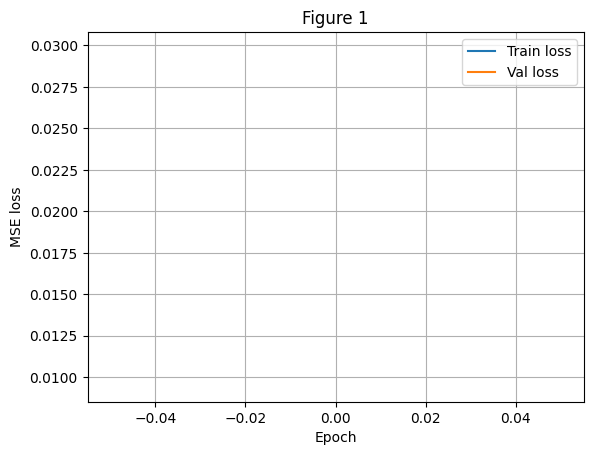

In [64]:
import matplotlib.pyplot as plt
def plot_losses(train_losses, validation_losses):
    plt.figure()
    plt.plot(train_losses, label="Train loss")
    plt.plot(validation_losses, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.legend()
    plt.grid(True)
    plt.title("Figure 1")
    plt.show()

plot_losses(train_losses, validation_losses)

### 4.2 Test performance

After training, we evaluate the model on the test set.  

In [70]:
test_loss = evaluate_model(trainedModel, test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0094


### 4.3 Visual inspection

Figure 2 illustrates some original input images and their reconstructions.  
The reconstructions are slightly blurred but preserve the main objects and colours, which is expected for a simple convolutional autoencoder.


In [53]:
import torch
import matplotlib.pyplot as plt

def show_reconstruction(model, test_loader, device=device, num_images=5, title=""):
    model.eval()

    # 1. Take a single batch from the test (or val) loader
    img, _ = next(iter(test_loader)) 
    img = img.to(device)

    # 2. Get reconstructions
    with torch.no_grad():
        reconstruction, latent = model(img)         

    # 3. Move to CPU and (optionally) undo normalization
    orig = img.cpu()
    rec  = reconstruction.cpu()

    # 4. Plot first 7 originals and their reconstructions
    n_show = 7
    fig, ax = plt.subplots(2, n_show, figsize=(15, 4), dpi=250)

    for i in range(n_show):
        # [C, H, W] -> [H, W, C]
        img_np = orig[i].numpy().transpose((1, 2, 0))
        rec_np = rec[i].numpy().transpose((1, 2, 0))

        ax[0, i].imshow(img_np)
        ax[0, i].axis('off')

        ax[1, i].imshow(rec_np)
        ax[1, i].axis('off')
    ax[0, 0].set_title('Original')
    ax[1, 0].set_title('Reconstructed')
    plt.tight_layout()
    plt.show()

    # remember to add title to the graph 


In [ ]:
models_to_test = {
    "Base": ConvolutionAutoEncoder(),
    "Simple": ShallowConvolutionAutoEncoder(),
    "Deep": DeepConvolutionAutoEncoder(),
    "WideKernel": BiggerFilterConvolutionAutoEncoder(),
    "Strided": StridedConvolutionAutoEncoder()
}

trained_models = {}

results = {}

for name, model in models_to_test.items():
    print(f"\n======================")
    print(f"Training model: {name}")
    print(f"======================")

    trained_model, train_losses, validation_losses = train_model(model, train_loader, val_loader, epochs=10, learning_rate=1e-3)
    
    # Saving the trained model
    torch.save(trained_model.state_dict(), f'{name.lower()}_conv_autoencoder.pth')

    # Evaluate on test or validation set
    val_loss = evaluate_model(trained_model, val_loader)
    
    results[name] = {
        "model": trained_model,
        "val_loss": val_loss
    }

    print(f"Validation/Test Loss for {name}: {val_loss:.6f}")



# Show summary of results
print("\n Model Performance Summary:")
for name, entry in results.items():
    print(f"{name:<15} | Validation/Test Loss: {entry['val_loss']:.6f}")

# Optionally, show all the reconstructions
for name, entry in results.items():
    model = entry["model"]
    show_reconstruction(model, test_loader, device=device, title=f"Reconstruction - {name}")



Training model: Base
[Epoch 1/5] Step 100/375 Batch loss: 0.0223
[Epoch 1/5] Step 200/375 Batch loss: 0.0123
[Epoch 1/5] Step 300/375 Batch loss: 0.0100
Epoch 1/5 - Train: 0.0324, Val: 0.0098
Validation/Test Loss for Base: 0.009768

Training model: Simple
[Epoch 1/5] Step 100/375 Batch loss: 0.0221
[Epoch 1/5] Step 200/375 Batch loss: 0.0131
[Epoch 1/5] Step 300/375 Batch loss: 0.0106


KeyboardInterrupt: 